In [1]:
# libraries used
import boto3
import diff_classifier.aws as aws
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from diff_classifier.features import calculate_features
from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

import altair as alt
from matplotlib import colors as plt_colors
from mpl_toolkits.mplot3d import Axes3D


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from kneed import KneeLocator

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import shap

In [2]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [3]:
dataset_path = workbookDir + '/region_feature_folder/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f)) and 'feat' in f]
filelist

['feat_NT_slice_2_striatum_vid_4.csv',
 'feat_NT_slice_2_striatum_vid_5.csv',
 'feat_NT_slice_1_striatum_vid_1.csv',
 'feat_NT_slice_2_cortex_vid_4.csv',
 'feat_NT_slice_1_striatum_vid_3.csv',
 'feat_NT_slice_1_cortex_vid_10.csv',
 'feat_NT_slice_1_striatum_vid_2.csv',
 'feat_NT_slice_2_cortex_vid_5.csv',
 'feat_NT_slice_2_cortex_vid_1.csv',
 'feat_NT_slice_2_hippocampus_vid_2.csv',
 'feat_NT_slice_2_striatum_vid_2.csv',
 'feat_NT_slice_2_striatum_vid_3.csv',
 'feat_NT_slice_2_hippocampus_vid_3.csv',
 'feat_NT_slice_2_cortex_vid_2.csv',
 'feat_NT_slice_1_cortex_vid_8.csv',
 'feat_NT_slice_1_striatum_vid_5.csv',
 'feat_NT_slice_2_hippocampus_vid_1.csv',
 'feat_NT_slice_2_striatum_vid_1.csv',
 'feat_NT_slice_1_striatum_vid_4.csv',
 'feat_NT_slice_1_cortex_vid_9.csv',
 'feat_NT_slice_2_cortex_vid_3.csv',
 'feat_NT_slice_1_hippocampus_vid_1.csv',
 'feat_NT_slice_1_hippocampus_vid_3.csv',
 'feat_NT_slice_1_hippocampus_vid_2.csv',
 'feat_NT_slice_2_ganglia_vid_3.csv',
 'feat_NT_slice_2_gangl

In [4]:
fstats_tot = None
video_num = 0
for filename in filelist:
#     try:
        fstats = pd.read_csv(dataset_path + filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        if 'cortex' in filename:
            fstats['region'] = pd.Series(fstats.shape[0]*['cortex'], index=fstats.index)
        elif 'striatum' in filename:
            fstats['region'] = pd.Series(fstats.shape[0]*['striatum'], index=fstats.index)
        elif 'ganglia' in filename:
            fstats['region'] = pd.Series(fstats.shape[0]*['ganglia'], index=fstats.index)
        elif 'thalamus' in filename:
            fstats['region'] = pd.Series(fstats.shape[0]*['thalamus'], index=fstats.index)
        elif 'hippocampus' in filename:
            fstats['region'] = pd.Series(fstats.shape[0]*['hippocampus'], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[video_num], index=fstats.index)
        if fstats_tot is None:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        video_num += 1

feat_NT_slice_2_striatum_vid_4.csv size: (10237, 67)
feat_NT_slice_2_striatum_vid_5.csv size: (13938, 67)
feat_NT_slice_1_striatum_vid_1.csv size: (2431, 67)
feat_NT_slice_2_cortex_vid_4.csv size: (1429, 67)
feat_NT_slice_1_striatum_vid_3.csv size: (1536, 67)
feat_NT_slice_1_cortex_vid_10.csv size: (4832, 67)
feat_NT_slice_1_striatum_vid_2.csv size: (2240, 67)
feat_NT_slice_2_cortex_vid_5.csv size: (2210, 67)
feat_NT_slice_2_cortex_vid_1.csv size: (1388, 67)
feat_NT_slice_2_hippocampus_vid_2.csv size: (46, 67)
feat_NT_slice_2_striatum_vid_2.csv size: (10500, 67)
feat_NT_slice_2_striatum_vid_3.csv size: (11355, 67)
feat_NT_slice_2_hippocampus_vid_3.csv size: (307, 67)
feat_NT_slice_2_cortex_vid_2.csv size: (1784, 67)
feat_NT_slice_1_cortex_vid_8.csv size: (1984, 67)
feat_NT_slice_1_striatum_vid_5.csv size: (2169, 67)
feat_NT_slice_2_hippocampus_vid_1.csv size: (250, 67)
feat_NT_slice_2_striatum_vid_1.csv size: (8314, 67)
feat_NT_slice_1_striatum_vid_4.csv size: (2177, 67)
feat_NT_slice_

In [5]:
fstats_tot.columns
fstats_tot.head()

,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,...,Mean Mean_Intensity,Std Mean_Intensity,Mean SN_Ratio,Std SN_Ratio,Mean Deff1,Std Deff1,Mean Deff2,Std Deff2,region,Video Number
0,0.0,1.611765e-02,26.711181,3.288428,0.945602,0.118247,0.372335,2.366365,0.577411,0.097441,...,NaN,NaN,0.767566,0.170583,0.959069,1.306709,0.100702,0.109127,striatum,0
1,1.0,1.567008e-08,0.619012,2.837829,0.300884,0.539952,0.045650,1.128631,0.113970,0.251949,...,NaN,NaN,0.944781,0.389032,0.196385,0.214294,0.018856,0.020472,striatum,0
2,2.0,3.825253e-01,0.025727,3.874284,0.038580,0.819546,0.004930,1.091210,0.083586,0.058152,...,NaN,NaN,0.668841,0.169089,1.263415,2.049538,0.255571,0.469424,striatum,0
3,3.0,NaN,NaN,32.947937,0.981209,0.068865,0.477143,6.559554,0.847551,0.017961,...,NaN,NaN,0.668841,0.169089,1.263415,2.049538,0.255571,0.469424,striatum,0
4,4.0,4.294176e-01,0.240604,2.306450,0.156974,0.657617,0.021563,1.523668,0.343689,0.013608,...,NaN,NaN,0.944781,0.389032,0.196385,0.214294,0.018856,0.020472,striatum,0


In [6]:
fstats_tot
features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
   # 'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'region'           # prediction target (y)


linear_features = [
    'Mean Deff1',
    'Mean D_fit',
    'Mean fractal_dim',
    'Mean MSD_ratio',
    'Mean kurtosis',
    'Mean straightness'
    ]
    
ecm = fstats_tot
ecm = fstats_tot[features + [target] + ['X'] + ['Y']]
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)] 

In [7]:
#--------------NOT-ADDED-----------------------------
def balance_data(df, target, **kwargs):
    if 'random_state' not in kwargs:
        random_state = 1
    else:
        random_state = kwargs['random_state']
    if isinstance(target, list):
        target = target[0]
    df_target = []
    bal_df = []
    for name in df[target].unique():
        df_target.append((name, df[df[target] == name]))
    print(f"Ratio before data balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i[1])) for i in df_target])}")
    for i in range(len(df_target)):
        ratio = min([len(i[1]) for i in df_target])/len(df_target[i][1])
        bal_df.append(df_target[i][1].sample(frac=ratio, random_state=random_state))
    print(f"Ratio after balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i)) for i in bal_df])}")
    return pd.concat(bal_df)
bal_ecm = balance_data(ecm, target, random_state=1)

Ratio before data balance (striatum:cortex:hippocampus:ganglia:thalamus) = 17401:6575:124:233:186
Ratio after balance (striatum:cortex:hippocampus:ganglia:thalamus) = 124:124:124:124:124


In [8]:
resolution = 128
assert not 2048%resolution and resolution >= 128, "resolution needs to be a factor of 2048 and > 128"
bins = list(range(0, 2048+1, resolution))
bin_labels = [int(i/resolution) for i in bins][:-1]
bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=bin_labels, include_lowest=True)
bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=bin_labels, include_lowest=True)
bal_ecm['bins'] = (len(bins)-1)*bal_ecm['binx'].astype(np.int32) + bal_ecm['biny'].astype(np.int32)
bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
bal_ecm['bins'] = bal_ecm['bins'].astype(int)

In [9]:
label_df = bal_ecm[target]
features_df = bal_ecm[features]
result = pd.concat([df2, label_df], axis=1)
#result_small = result.sample(5000)
result_cleaned = result[~result.isin([np.nan, np.inf, -np.inf]).any(1)] # Remove inf and nan points
result_cleaned['region'].unique()

ss = StandardScaler()
scaled_features_all = ss.fit_transform(result_cleaned[features].values)
scaled_features_best = ss.fit_transform(result_cleaned[linear_features].values)

NameError: name 'df2' is not defined

In [156]:
# View a portion of our data
result_cleaned.head()

,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,fractal_dim,...,Mean elongation,Mean boundedness,Mean fractal_dim,Mean trappedness,Mean efficiency,Mean straightness,Mean MSD_ratio,Mean Deff1,Mean Deff2,region
52109,0.814934,3.749037e-03,2.044072,0.976163,0.077662,0.456109,1.764654,0.433317,0.012997,2.972173,...,0.581590,0.043386,2.622227,-0.214068,0.197869,0.046234,0.281914,0.025318,0.006655,striatum
70146,0.526831,4.908777e-03,3.184034,0.316643,0.528987,0.048612,1.114603,0.102820,0.046243,3.955361,...,0.272106,0.067266,3.871588,-0.206811,0.017044,0.012641,0.603919,0.005898,0.000638,striatum
53956,1.869663,4.115691e-06,1.920681,0.977814,0.074892,0.462609,2.695302,0.628984,0.012726,3.061329,...,0.440444,0.069076,3.113777,-0.206271,0.065400,0.040315,0.472869,0.021209,0.001615,striatum
66663,0.062569,7.473040e-01,3.270900,0.634800,0.336340,0.131611,1.824691,0.451962,0.062980,3.021642,...,0.448102,0.078851,1.863402,-0.203307,0.338540,0.140927,0.887063,0.922658,0.390614,striatum
77759,4.650397,3.065351e-09,21.288547,0.615969,0.347204,0.124880,1.342299,0.255009,0.012026,1.625583,...,0.545124,0.078530,1.758271,-0.203415,0.391110,0.140874,4.929139,1.201263,0.276368,striatum


### Pairplot visualizations

In [157]:
scaled_features_best

array([[-0.75407042, -0.84209307,  0.87185024, -0.21493251, -0.44970263,
        -0.9932698 ],
       [-0.75932599, -0.85536122,  3.3242375 , -0.14268814, -0.39234773,
        -1.42323195],
       [-0.75518229, -0.85118329,  1.83671983, -0.17209011,  0.05130239,
        -1.06903283],
       ...,
       [ 2.53514589,  0.90318124, -0.92866376, -0.14876167, -0.42677864,
         1.85357124],
       [ 0.19504943,  0.92958603, -0.59748113, -0.02719381, -0.38898735,
        -0.11893478],
       [ 1.81197888,  1.29834885, -1.01986679, -0.24836188, -0.72836579,
         2.15074381]])

(620, 34)

In [233]:
sns.pairplot(result_cleaned, hue='region')
plt.savefig('pairplot_2.png', dpi=300)

Error in callback <function flush_figures at 0x7f8959bdc8c0> (for post_execute):


KeyboardInterrupt: 

### Analysis and visualization of data using PCA, TSNE, UMAP

To get a sense of the data distribution, we are going to apply PCA to reduce dimensionality so we can visualize the data better

In [113]:
# Get the components usng PCA

pca = PCA(n_components=4)
components = pca.fit_transform(scaled_features)
print((scaled_features.shape))
print(pca.explained_variance_ratio_.sum())

(620, 33)
0.5555024582762622


In [126]:
# Get components with TSNE
tsne = TSNE(n_components=3)
tsne_comps = tsne.fit_transform(scaled_features_all)


In [133]:
tsne_df['region'].unique()

array(['striatum', 'cortex', 'hippocampus', 'ganglia', 'thalamus'],
      dtype=object)

striatum
cortex
hippocampus
ganglia
thalamus


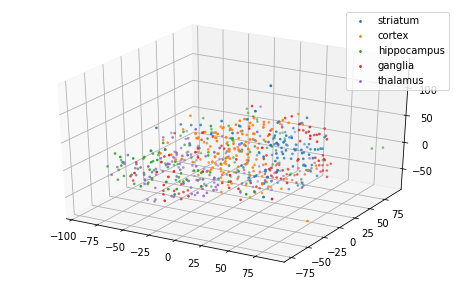

In [146]:
tsne_df = pd.DataFrame({'comp_1': tsne_comps[:, 0],
                        'comp_2': tsne_comps[:, 1],
                        'comp_3': tsne_comps[:, 2],
                        'region': label_df.values})


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

for region in tsne_df['region'].unique():
    df = tsne_df[tsne_df['region'] == region]
    print(region)
    ax.scatter(xs=df['comp_1'], ys=df['comp_2'], zs=df['comp_3'], label=region, s=3)
ax.legend()
# alt.Chart(tsne_df).mark_point().encode(
#     x='comp_1',
#     y='comp_2',
#     color='region'
# )


In [114]:
# Visualize the components
pca_df = pd.DataFrame({'component_1': components[:, 0], 
                        'component_2': components[:, 1], 
                        'component_3': components[:, 2], 
                        'component_4': components[:, 3],
                        'region': label_df.values})
pca_df.head()
#pca_df = pd.concat([pca_df, label_df], axis=1)


# alt.Chart(pca_df).mark_point().encode(
#     x='component_1',
#     y='component_2',
#     color='region'
# )

# alt.Chart(pca_df).mark_point().encode(
#     x='component_1',
#     y='component_3',
#     color='region'
# )

alt.Chart(pca_df).mark_point().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='region:N'
).properties(
    width=100,
    height=100
).repeat(
    row=['component_1', 'component_2', 'component_3'],
    column=['component_2', 'component_3', 'component_4']
).interactive()

alt.RepeatChart(...)

In [ ]:
# Using UMAP algorithm

reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(scaled_features)


In [148]:
umap_df = pd.DataFrame({'component_1': components[:, 0], 
                        'component_2': components[:, 1], 
                        'region': label_df.values})

alt.Chart(umap_df).mark_point().encode(
    x='component_1',
    y='component_2',
    color='region'
)

alt.Chart(...)

### Clustering analysis
Here we apply a number of clustering algorithms to the data

In [12]:
X = result_cleaned[features]
print(len(result))
print(len(result_cleaned))
print(len(result_cleaned['region']))
print(len(X))
print()

ss = StandardScaler()
scaled_features = ss.fit_transform(X.values)
kmean = KMeans(n_clusters=5, init='k-means++').fit(scaled_features)
centroids = kmean.cluster_centers_

print('SSE value: ', kmean.inertia_)
print('Num iterations for convergence: ', kmean.n_iter_)
#spec = SpectralClustering(n_clusters=4).fit(X)

620
620
620
620

SSE value:  13649.851790366032
Num iterations for convergence:  16


In [221]:
def get_cluster_distributions(cluster_labels, df_with_target, n_clusters):

    for region in result_cleaned['region'].unique():
        idx = np.array(df_with_target['region'] == region)
        clust_labels = cluster_labels[idx]
        true_label = result_cleaned.iloc[idx]
        print('Region:', region)
        for i in range(0, n_clusters):
            ct = (clust_labels == i).sum()
            percent = '{:.2%}'.format(ct/len(clust_labels))
            print('Percent in cluster', i,'=', percent)
        print()
get_cluster_distributions(kmean.labels_, result_cleaned, 5)

Region: striatum
Percent in cluster 0 = 53.23%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 0.00%
Percent in cluster 3 = 0.00%
Percent in cluster 4 = 46.77%

Region: cortex
Percent in cluster 0 = 19.35%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 5.65%
Percent in cluster 3 = 0.00%
Percent in cluster 4 = 75.00%

Region: hippocampus
Percent in cluster 0 = 29.84%
Percent in cluster 1 = 0.81%
Percent in cluster 2 = 52.42%
Percent in cluster 3 = 0.81%
Percent in cluster 4 = 16.13%

Region: ganglia
Percent in cluster 0 = 52.42%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 20.16%
Percent in cluster 3 = 0.00%
Percent in cluster 4 = 27.42%

Region: thalamus
Percent in cluster 0 = 27.42%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 55.65%
Percent in cluster 3 = 0.00%
Percent in cluster 4 = 16.94%



In [24]:
agg = AgglomerativeClustering(n_clusters=5).fit(scaled_features)
get_cluster_distributions(agg.labels_, result_cleaned, 5)

Region: striatum
Percent in cluster 0 = 0.00%
Percent in cluster 1 = 0.81%
Percent in cluster 2 = 27.42%
Percent in cluster 3 = 62.90%
Percent in cluster 4 = 8.87%

Region: cortex
Percent in cluster 0 = 6.45%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 20.97%
Percent in cluster 3 = 71.77%
Percent in cluster 4 = 0.81%

Region: hippocampus
Percent in cluster 0 = 42.74%
Percent in cluster 1 = 4.03%
Percent in cluster 2 = 30.65%
Percent in cluster 3 = 17.74%
Percent in cluster 4 = 4.84%

Region: ganglia
Percent in cluster 0 = 12.90%
Percent in cluster 1 = 0.81%
Percent in cluster 2 = 28.23%
Percent in cluster 3 = 32.26%
Percent in cluster 4 = 25.81%

Region: thalamus
Percent in cluster 0 = 58.87%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 32.26%
Percent in cluster 3 = 8.06%
Percent in cluster 4 = 0.81%



In [25]:
spec = SpectralClustering(n_clusters=5).fit(scaled_features)
get_cluster_distributions(spec.labels_, result_cleaned, 5)

Region: striatum
Percent in cluster 0 = 100.00%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 0.00%
Percent in cluster 3 = 0.00%
Percent in cluster 4 = 0.00%

Region: cortex
Percent in cluster 0 = 100.00%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 0.00%
Percent in cluster 3 = 0.00%
Percent in cluster 4 = 0.00%

Region: hippocampus
Percent in cluster 0 = 99.19%
Percent in cluster 1 = 0.81%
Percent in cluster 2 = 0.00%
Percent in cluster 3 = 0.00%
Percent in cluster 4 = 0.00%

Region: ganglia
Percent in cluster 0 = 100.00%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 0.00%
Percent in cluster 3 = 0.00%
Percent in cluster 4 = 0.00%

Region: thalamus
Percent in cluster 0 = 100.00%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 0.00%
Percent in cluster 3 = 0.00%
Percent in cluster 4 = 0.00%



In [26]:
guass = GaussianMixture(n_components=5).fit_predict(scaled_features)
get_cluster_distributions(guass, result_cleaned, 5)

Region: striatum
Percent in cluster 0 = 30.65%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 56.45%
Percent in cluster 3 = 6.45%
Percent in cluster 4 = 6.45%

Region: cortex
Percent in cluster 0 = 6.45%
Percent in cluster 1 = 18.55%
Percent in cluster 2 = 40.32%
Percent in cluster 3 = 29.84%
Percent in cluster 4 = 4.84%

Region: hippocampus
Percent in cluster 0 = 25.00%
Percent in cluster 1 = 42.74%
Percent in cluster 2 = 5.65%
Percent in cluster 3 = 7.26%
Percent in cluster 4 = 19.35%

Region: ganglia
Percent in cluster 0 = 30.65%
Percent in cluster 1 = 22.58%
Percent in cluster 2 = 34.68%
Percent in cluster 3 = 0.81%
Percent in cluster 4 = 11.29%

Region: thalamus
Percent in cluster 0 = 9.68%
Percent in cluster 1 = 60.48%
Percent in cluster 2 = 4.84%
Percent in cluster 3 = 1.61%
Percent in cluster 4 = 23.39%



In [32]:
bay_gauss = BayesianGaussianMixture(n_components=5).fit_predict(scaled_features)
get_cluster_distributions(bay_gauss, result_cleaned, 5)

Region: striatum
Percent in cluster 0 = 41.13%
Percent in cluster 1 = 0.00%
Percent in cluster 2 = 4.03%
Percent in cluster 3 = 10.48%
Percent in cluster 4 = 44.35%

Region: cortex
Percent in cluster 0 = 13.71%
Percent in cluster 1 = 5.65%
Percent in cluster 2 = 18.55%
Percent in cluster 3 = 2.42%
Percent in cluster 4 = 59.68%

Region: hippocampus
Percent in cluster 0 = 16.13%
Percent in cluster 1 = 8.87%
Percent in cluster 2 = 56.45%
Percent in cluster 3 = 8.06%
Percent in cluster 4 = 10.48%

Region: ganglia
Percent in cluster 0 = 38.71%
Percent in cluster 1 = 1.61%
Percent in cluster 2 = 29.84%
Percent in cluster 3 = 6.45%
Percent in cluster 4 = 23.39%

Region: thalamus
Percent in cluster 0 = 7.26%
Percent in cluster 1 = 8.06%
Percent in cluster 2 = 75.00%
Percent in cluster 3 = 6.45%
Percent in cluster 4 = 3.23%



In [29]:
affinity = AffinityPropagation().fit(scaled_features)
affinity.cluster_centers_.shape

(63, 33)

In [176]:
db = DBSCAN(eps=2.3).fit(scaled_features_all)
db.labels_

array([ 0,  0,  0,  0, -1, -1, -1,  0, -1, -1,  0,  0,  0, -1,  0,  0, -1,
       -1,  0,  0, -1, -1, -1, -1,  0,  1, -1,  0,  0,  0,  0,  2,  0,  0,
        0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0,  0,  0,  0, -1,  0,  0,
       -1,  0,  0, -1,  0,  0, -1, -1,  0, -1,  0, -1,  0, -1, -1, -1,  0,
        0,  0,  0, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1,  0,  0,  0,
        0, -1,  0, -1, -1, -1,  0,  0,  1, -1, -1,  0, -1, -1, -1, -1,  0,
        1,  0, -1,  0, -1, -1,  0, -1, -1, -1,  0,  0, -1, -1,  0,  0,  0,
       -1, -1,  0,  0,  0,  0, -1, -1, -1,  0, -1,  0,  0,  0,  0, -1, -1,
        0,  0, -1,  0, -1,  0,  3,  0, -1, -1,  0,  0,  0, -1,  0,  0,  0,
        1, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0,  0, -1,
        0, -1, -1, -1, -1, -1,  0, -1,  0,  0, -1, -1,  0,  0, -1,  0, -1,
        0,  0,  0, -1,  0,  0,  0,  0, -1,  0, -1, -1, -1,  0, -1,  0, -1,
        0, -1,  0,  0, -1, -1, -1, -1,  0,  0, -1, -1,  0, -1, -1,  0,  0,
        0, -1, -1,  0,  0

In [211]:
# Implementing DBSCAN
eps_list = [2.1, 2.2, 2.3, 2.4, 2.5]
num_outliers = []
num_clusters = []
for eps in eps_list:
    db = DBSCAN(eps=eps).fit(scaled_features_all)
    labels = db.labels_
    outlier_ct = (labels == -1).sum()
    num_outliers.append(outlier_ct)
    num_clusters.append(len(np.unique(labels)))

print(len(eps_list))
print(len(num_outliers))
print(len(num_clusters))

5
5
5


In [212]:
db_df = pd.DataFrame({'eps': eps_list,
                       'outliers': num_outliers,
                       'clusters': num_clusters})


alt.Chart(db_df).mark_point().encode(
    x='eps',
    y='outliers'
)

alt.Chart(...)

In [213]:
alt.Chart(db_df).mark_point().encode(
    x='eps',
    y='clusters'
)

alt.Chart(...)

In [220]:
db_best = DBSCAN(eps=2.5).fit(scaled_features_all)
np.unique(db_best.labels_)

array([-1,  0,  1,  2,  3,  4])

In [229]:
db_best.labels_
for region in result_cleaned['region'].unique():
        idx = np.array(result_cleaned['region'] == region)
        clust_labels = db_best.labels_[idx]
        true_label = result_cleaned.iloc[idx]
        print('Region:', region)
        for i in range(-1, len(np.unique(db_best.labels_))-1):
            ct = (clust_labels == i).sum()
            percent = '{:.2%}'.format(ct/len(clust_labels))
            print('Percent in cluster', i,'=', percent)
        print()

Region: striatum
Percent in cluster -1 = 33.06%
Percent in cluster 0 = 62.90%
Percent in cluster 1 = 2.42%
Percent in cluster 2 = 1.61%
Percent in cluster 3 = 0.00%
Percent in cluster 4 = 0.00%

Region: cortex
Percent in cluster -1 = 32.26%
Percent in cluster 0 = 66.13%
Percent in cluster 1 = 0.81%
Percent in cluster 2 = 0.00%
Percent in cluster 3 = 0.81%
Percent in cluster 4 = 0.00%

Region: hippocampus
Percent in cluster -1 = 75.81%
Percent in cluster 0 = 16.94%
Percent in cluster 1 = 1.61%
Percent in cluster 2 = 5.65%
Percent in cluster 3 = 0.00%
Percent in cluster 4 = 0.00%

Region: ganglia
Percent in cluster -1 = 45.97%
Percent in cluster 0 = 50.81%
Percent in cluster 1 = 0.81%
Percent in cluster 2 = 0.00%
Percent in cluster 3 = 2.42%
Percent in cluster 4 = 0.00%

Region: thalamus
Percent in cluster -1 = 80.65%
Percent in cluster 0 = 9.68%
Percent in cluster 1 = 0.81%
Percent in cluster 2 = 0.00%
Percent in cluster 3 = 3.23%
Percent in cluster 4 = 5.65%

